# Reward System Evaluation

This notebook evaluates and visualizes the reward system implemented in `ypl/backend/routes/v1/reward.py`.

In [1]:
from uuid import UUID

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone

# Add the project root to the Python path
sys.path.append(os.path.abspath('../..'))

from ypl.backend.llm.reward import (
    UserTurnReward,
    get_reward,
    get_tiered_reward,
    reward,
    MEAN_EVAL_REWARD,
    REWARD_TIERS,
)

## Analyzing Tiered Rewards

Counter({10: 1839, 20: 154, 30: 7})
Counter({60: 1030, 50: 980, 70: 510, 80: 265, 90: 121, 100: 52, 110: 25, 120: 9, 130: 5, 200: 1, 150: 1, 140: 1})
Counter({220: 266, 210: 247, 230: 178, 240: 168, 200: 135, 250: 125, 260: 116, 280: 98, 270: 84, 290: 77, 300: 77, 320: 66, 310: 57, 330: 46, 340: 34, 350: 27, 380: 26, 390: 20, 360: 19, 420: 19, 370: 13, 400: 12, 410: 11, 430: 10, 480: 8, 490: 7, 470: 6, 500: 5, 450: 5, 510: 4, 440: 4, 580: 4, 460: 3, 550: 3, 520: 3, 610: 2, 560: 2, 600: 2, 590: 2, 530: 2, 650: 1, 680: 1, 640: 1, 570: 1, 540: 1, 750: 1, 800: 1})


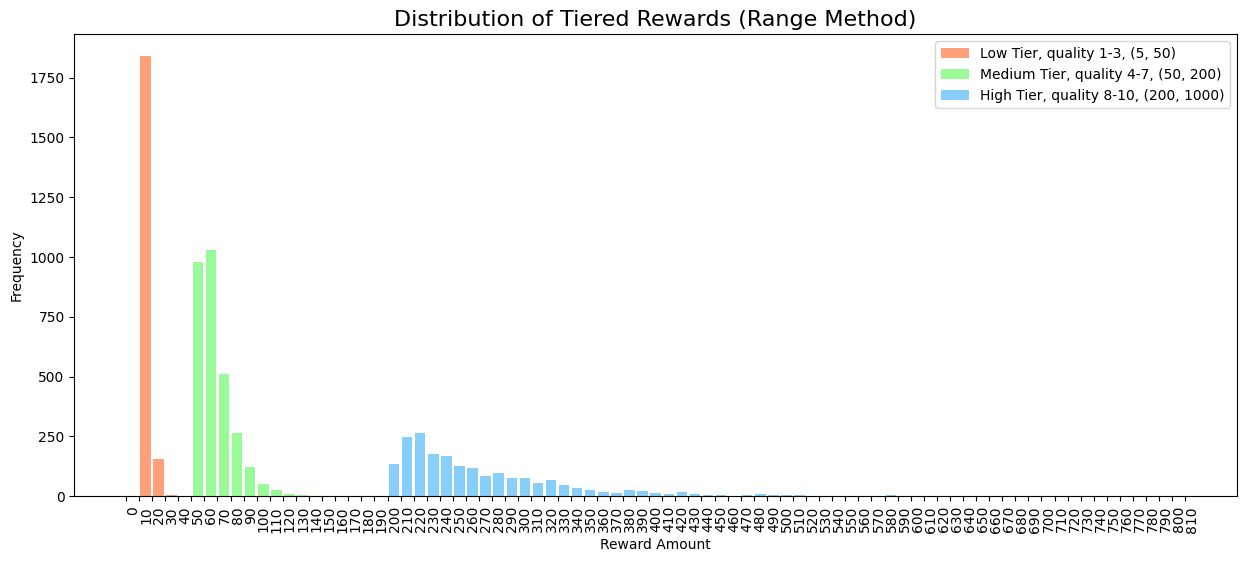

Range method:
Mean reward for low tier (1-3): 10.84
Mean reward for medium tier (4-7): 62.92
Mean reward for high tier (8-10): 268.74


In [14]:
from collections import Counter

def plot_tiered_rewards_histogram():
    quality_scores = np.linspace(1, 11, 10000)
    rewards_range = [get_tiered_reward(score, method="range") for score in quality_scores]

    # Calculate mean rewards for each tier using range method
    low_tier_mean = np.mean([r for r, s in zip(rewards_range, quality_scores) if 1 <= s <= 3])
    medium_tier_mean = np.mean([r for r, s in zip(rewards_range, quality_scores) if 4 <= s <= 7])
    high_tier_mean = np.mean([r for r, s in zip(rewards_range, quality_scores) if 8 <= s <= 10])

    # Separate rewards by tier
    low_tier_rewards = [r for r, s in zip(rewards_range, quality_scores) if 1 <= s <= 3]
    medium_tier_rewards = [r for r, s in zip(rewards_range, quality_scores) if 4 <= s <= 7]
    high_tier_rewards = [r for r, s in zip(rewards_range, quality_scores) if 8 <= s <= 10]

    print(Counter(low_tier_rewards))
    print(Counter(medium_tier_rewards))
    print(Counter(high_tier_rewards))

    plt.figure(figsize=(15, 6))
    
    # Create bins for rewards in denominations of 10
    bins = range(0, max(rewards_range) + 11, 10)
    
    # Plot bar charts for each tier with updated labels
    plt.hist([low_tier_rewards, medium_tier_rewards, high_tier_rewards], 
             bins=bins,
             stacked=True, 
             label=[f'Low Tier, quality 1-3, {REWARD_TIERS["low"].reward_range}', 
                    f'Medium Tier, quality 4-7, {REWARD_TIERS["medium"].reward_range}', 
                    f'High Tier, quality 8-10, {REWARD_TIERS["high"].reward_range}'],
             color=['#FFA07A', '#98FB98', '#87CEFA'],  # Light colors for better visibility
             rwidth=0.8)  # Adjust bar width

    plt.title("Distribution of Tiered Rewards (Range Method)", fontsize=16)
    plt.xlabel("Reward Amount")
    plt.ylabel("Frequency")
    
    plt.legend()
    plt.xticks(bins, rotation=90, ha='left')  # Rotate x-axis labels by 45 degrees
    plt.show()

    # Print mean rewards for each tier
    print("Range method:")
    print(f"Mean reward for low tier (1-3): {low_tier_mean:.2f}")
    print(f"Mean reward for medium tier (4-7): {medium_tier_mean:.2f}")
    print(f"Mean reward for high tier (8-10): {high_tier_mean:.2f}")

plot_tiered_rewards_histogram()

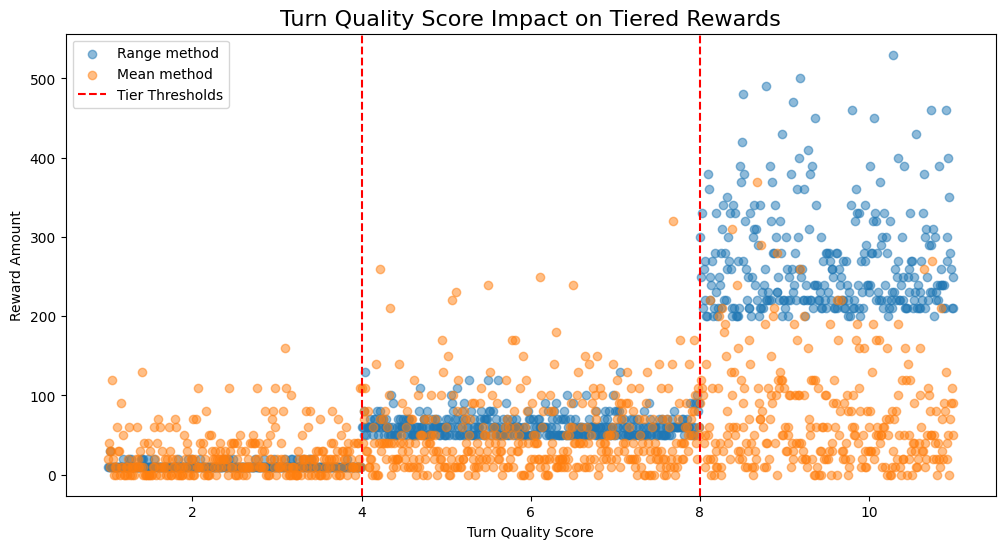

Range method:
Mean reward for low tier (1-3): 11.00
Mean reward for medium tier (4-7): 62.00
Mean reward for high tier (8-10): 267.90

Mean method:
Mean reward for low tier (1-3): 23.25
Mean reward for medium tier (4-7): 49.73
Mean reward for high tier (8-10): 76.95


In [15]:
def plot_tiered_rewards():
    quality_scores = np.linspace(1, 11, 1000)
    rewards_range = [get_tiered_reward(score, method="range") for score in quality_scores]
    rewards_mean = [get_tiered_reward(score, method="mean") for score in quality_scores]

    # Calculate mean rewards for each tier using range method
    low_tier_mean_range = np.mean([r for r, s in zip(rewards_range, quality_scores) if 1 <= s <= 3])
    medium_tier_mean_range = np.mean([r for r, s in zip(rewards_range, quality_scores) if 4 <= s <= 7])
    high_tier_mean_range = np.mean([r for r, s in zip(rewards_range, quality_scores) if 8 <= s <= 10])

    # Calculate mean rewards for each tier using mean method
    low_tier_mean_mean = np.mean([r for r, s in zip(rewards_mean, quality_scores) if 1 <= s <= 3])
    medium_tier_mean_mean = np.mean([r for r, s in zip(rewards_mean, quality_scores) if 4 <= s <= 7])
    high_tier_mean_mean = np.mean([r for r, s in zip(rewards_mean, quality_scores) if 8 <= s <= 10])

    plt.figure(figsize=(12, 6))
    plt.scatter(quality_scores, rewards_range, alpha=0.5, label='Range method')
    plt.scatter(quality_scores, rewards_mean, alpha=0.5, label='Mean method')
    plt.title("Turn Quality Score Impact on Tiered Rewards", fontsize=16)
    plt.xlabel("Turn Quality Score")
    plt.ylabel("Reward Amount")
    plt.axvline(x=4, color='r', linestyle='--', label='Tier Thresholds')
    plt.axvline(x=8, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # Print mean rewards for each tier and method
    print("Range method:")
    print(f"Mean reward for low tier (1-3): {low_tier_mean_range:.2f}")
    print(f"Mean reward for medium tier (4-7): {medium_tier_mean_range:.2f}")
    print(f"Mean reward for high tier (8-10): {high_tier_mean_range:.2f}")
    print("\nMean method:")
    print(f"Mean reward for low tier (1-3): {low_tier_mean_mean:.2f}")
    print(f"Mean reward for medium tier (4-7): {medium_tier_mean_mean:.2f}")
    print(f"Mean reward for high tier (8-10): {high_tier_mean_mean:.2f}")

plot_tiered_rewards()

## Analyzing Reward Probabilities

In [3]:
# Examples for each condition
user_turn_pairs = [
    ("clznau4k40000u19oxzncg4ny", UUID("e70c4508-fd99-41c9-9a2e-25b2cbbbe242")),  # first_turn
    ("cm25d6sg7000ho07ehddv0odq", UUID("bf0ac9ba-ddf5-4150-a0d2-7806904b89d9")),  # new_user
    ("b8d3bf74-3a22-4b12-bb1c-fb8f482db8ce", UUID("ad111784-94c7-4c3d-8560-135e86d86998")),  # inactive_user
    ("clznmob8s0000juhee1ik7zor", UUID("2e97d9c9-4bcf-4dc6-8fb3-ed791a66ff25")),  # typical_user
]

/Users/carmenlai/mambaforge/envs/ys-dev/lib/python3.11/site-packages/sqlmodel/orm/session.py:66: SAWarning: SELECT statement has a cartesian product between FROM element(s) "users" and FROM element "turn_qualities".  Apply join condition(s) between each element to resolve.
  results = super().execute(


First Turn
Is First Turn: True
Is New User: False
Is Inactive User: False
===
New User
Is First Turn: False
Is New User: True
Is Inactive User: False
===
Inactive User
Is First Turn: False
Is New User: False
Is Inactive User: True
===
Typical User
Is First Turn: False
Is New User: False
Is Inactive User: False
===


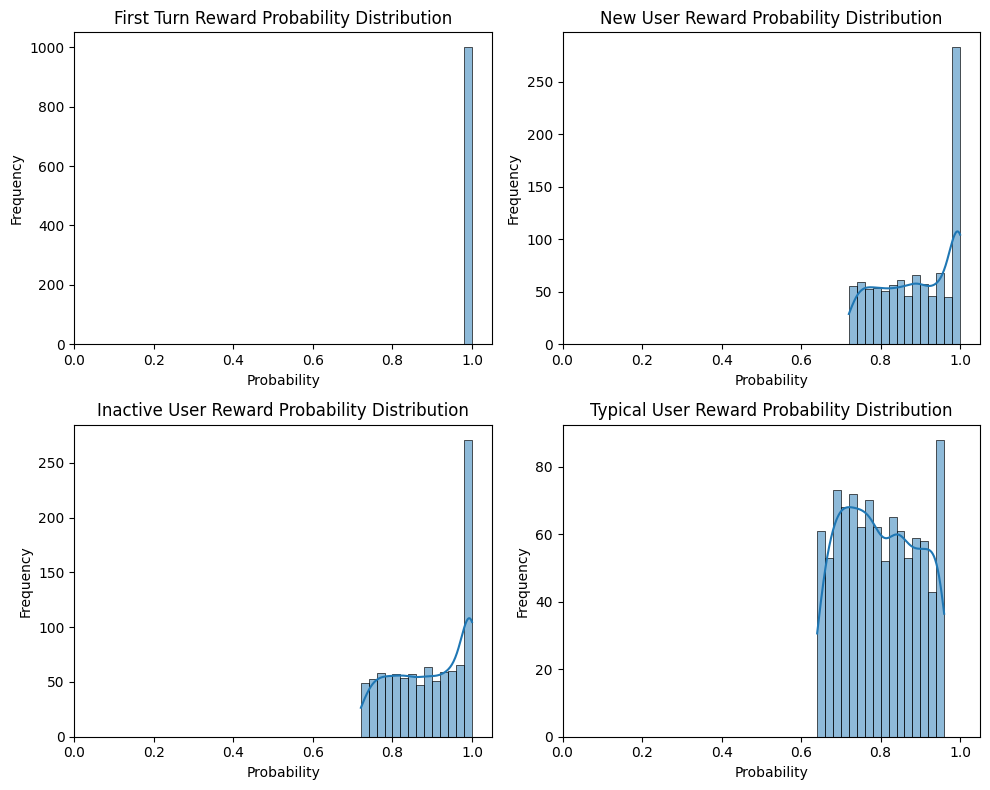

First Turn:
  Mean: 1.0000
  Median: 1.0000
  Std Dev: 0.0000
  Min: 1.0000
  Max: 1.0000

New User:
  Mean: 0.8913
  Median: 0.8990
  Std Dev: 0.0922
  Min: 0.7202
  Max: 1.0000

Inactive User:
  Mean: 0.8928
  Median: 0.9037
  Std Dev: 0.0912
  Min: 0.7206
  Max: 1.0000

Typical User:
  Mean: 0.7986
  Median: 0.7919
  Std Dev: 0.0934
  Min: 0.6404
  Max: 0.9598



In [4]:
import numpy as np
import seaborn as sns

def plot_reward_probability_distributions():
    user_types = ['First Turn', 'New User', 'Inactive User', 'Typical User']
    all_probabilities = []

    plt.figure(figsize=(10, 8))

    for i, (user_id, turn_id) in enumerate(user_turn_pairs):
        user_turn_reward = UserTurnReward(user_id=user_id, turn_id=turn_id)
        print(user_types[i])
        print(f"Is First Turn: {user_turn_reward.is_first_turn}")
        print(f"Is New User: {user_turn_reward.is_new_user}")
        print(f"Is Inactive User: {user_turn_reward.is_inactive_user}")
        print('===')

        probabilities = []
        for _ in range(1000):
            prob = user_turn_reward.calculate_reward_probability()
            probabilities.append(prob)
        
        all_probabilities.append(probabilities)
        
        plt.subplot(2, 2, i+1)
        sns.histplot(probabilities, kde=True, bins=50, binrange=(0, 1))
        plt.title(f"{user_types[i]} Reward Probability Distribution")
        plt.xlabel("Probability")
        plt.ylabel("Frequency")
        plt.xlim(0, 1.05)

    plt.tight_layout()
    plt.show()

    # Print summary statistics for each user type
    for user_type, probs in zip(user_types, all_probabilities):
        print(f"{user_type}:")
        print(f"  Mean: {np.mean(probs):.4f}")
        print(f"  Median: {np.median(probs):.4f}")
        print(f"  Std Dev: {np.std(probs):.4f}")
        print(f"  Min: {np.min(probs):.4f}")
        print(f"  Max: {np.max(probs):.4f}")
        print()

# Run the async function
plot_reward_probability_distributions()

In [5]:
user_turn_pairs = [
    ("clznmob8s0000juhee1ik7zor", UUID("48a2b3ed-b6e0-4a6e-ab70-276fc4356a30")),  # Low quality
    ("clznmob8s0000juhee1ik7zor", UUID("de10a719-5432-4200-84f8-aa587b71082b")),  # Medium quality
    ("clznmob8s0000juhee1ik7zor", UUID("0bcc002a-7b27-49be-96d8-2fdd65f7df24")),  # High quality
]

In [6]:
N_ITER = 10

def collect_reward_data():
    results = []
    user_types = ['Low quality', 'Medium quality', 'High quality']

    for i, (user_id, turn_id) in enumerate(user_turn_pairs):
        user_type = user_types[i]
        for _ in range(N_ITER):
            should_reward, reward_amount, reward_comment, reward_probability = reward(user_id, turn_id)
            results.append({
                'user_type': user_type,
                'should_reward': should_reward,
                'reward_amount': reward_amount,
                'reward_comment': reward_comment,
                'reward_probability': reward_probability
            })

    return pd.DataFrame(results)

# Run the function and create the DataFrame
reward_df = collect_reward_data()

# No need to expand reward tuple anymore
user_type_order = ['Low quality', 'Medium quality', 'High quality']
reward_df['user_type'] = pd.Categorical(reward_df['user_type'], categories=user_type_order, ordered=True)

In [7]:
# Note: actual reward function won't return score or reward probability, for debugging purposes only
print(reward_df.to_string(index=False))

     user_type  should_reward  reward_amount                                                         reward_comment  reward_probability
   Low quality          False            0.0                                        Keep engaging for more rewards!            0.671809
   Low quality           True           10.0                                       Thank you for participating. 2.0            0.909288
   Low quality           True            0.0                                       Thank you for participating. 2.0            0.804337
   Low quality           True            0.0                                       Thank you for participating. 2.0            0.790205
   Low quality           True            0.0                                       Thank you for participating. 2.0            0.900309
   Low quality           True            0.0                                       Thank you for participating. 2.0            0.889882
   Low quality           True           10.0    

In [10]:
reward_df.groupby('user_type')['reward_probability'].mean()

/var/folders/rr/j10x71jd6ss1v0t_2qvtwfq00000gn/T/ipykernel_50186/441108259.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reward_df.groupby('user_type')['reward_probability'].mean()


user_type
Low quality       0.809882
Medium quality    0.777146
High quality      0.829750
Name: reward_probability, dtype: float64

In [11]:
reward_df.groupby('user_type')['reward_amount'].mean()

/var/folders/rr/j10x71jd6ss1v0t_2qvtwfq00000gn/T/ipykernel_50186/2697471244.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reward_df.groupby('user_type')['reward_amount'].mean()


user_type
Low quality         2.0
Medium quality     47.0
High quality      245.0
Name: reward_amount, dtype: float64